In [2]:
'''
-------- For Colab ---------
from google.colab import drive
drive.mount('/content/drive')

!pip install shap
'''

import warnings
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a slice from a DataFrame")

Import all libraries necessary for the project. Load the data into data frames and view them. One key feature that stands out is the mismatch naming convention of keys. Correct this below:

In [4]:
import pandas as pd
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime

'''
# Load the data (for Colab)
contact = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/FinalProject/Contact.csv')
customerLoyalty = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/FinalProject/Customer-Loyalty.csv')
subscriptionHistory = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/FinalProject/SubscriptionHistoryContoso.csv')
'''

# Load the data
contact = pd.read_csv('Contact.csv')
customerLoyalty = pd.read_csv('Customer-Loyalty.csv')
subscriptionHistory = pd.read_csv('SubscriptionHistoryContoso.csv')

# See the data and columns to figure out what to work with
contact.head(1)
customerLoyalty.head(1)
subscriptionHistory.head(1)

# Fix the naming of primary key / foreign key
subscriptionHistory.rename(columns={'CustomerID': 'ContactId'}, inplace=True)


ModuleNotFoundError: No module named 'shap'

After viewing the data, it is clear there are some duplicate fields between Contact and CustomerLoyalty. Let's remove those fields and make some of the other ones more clear:

In [ ]:
# Remove duplicates of Contact from customerLoyalty
customerLoyalty.drop(columns=['FirstName', 'LastName', 'FullName', 'DateOfBirth', 'Gender', 'EMail', 'Telephone'], inplace=True)

# Rename CreatedOn columns to be Contact.AccountCreatedOn and CustomerLoyalty.LoyaltyCreatedOn
contact.rename(columns={'CreatedOn': 'AccountCreatedOn'}, inplace=True)
customerLoyalty.rename(columns={'CreatedOn': 'LoyaltyCreatedOn'}, inplace=True)

It is clear that some of these datapoints in Contact will not be helpful in this scenario, such as contact information. Let's remove these unhelpful fields to further process the data.

In [ ]:
contact.drop(columns=['FirstName', 'LastName', 'FullName', 'EMail', 'Telephone', 'StreetAddress', 'PostCode', 'Country', 'Headshot'], inplace=True)

As ContactIds are the key to merging the data, we must ensure they do not have bad data. When increasing the head size above, one datapoint can be found, leading to the following removal process. Once the invalid contactIds were removed, the ContactIds were stripped of their naming conventions down to just integers, making them easier to process. The same was done to LoyaltyIds.

In [ ]:
# Check ContactID for bad data
invalid_contact_ids = contact[~contact['ContactId'].str.startswith('CNTID')]['ContactId']

# Print out the invalid values
print("Invalid values:")
print(invalid_contact_ids)

# Remove these values and their rows from all tables, as this data is not usable.
contact = contact[~contact['ContactId'].isin(invalid_contact_ids)]
customerLoyalty = customerLoyalty[~customerLoyalty['ContactId'].isin(invalid_contact_ids)]
subscriptionHistory = subscriptionHistory[~subscriptionHistory['ContactId'].isin(invalid_contact_ids)]

# Remove the leading 'CNTID_' from all contactId columns
contact['ContactId'] = pd.to_numeric(contact['ContactId'].str.extract('(\d+)', expand=False))
customerLoyalty['ContactId'] = pd.to_numeric(customerLoyalty['ContactId'].str.extract('(\d+)', expand=False))
subscriptionHistory['ContactId'] = pd.to_numeric(subscriptionHistory['ContactId'].str.extract('(\d+)', expand=False))

# Remove the leading 'LOYID_' from all LoyaltyId columns
customerLoyalty['LoyaltyId'] = pd.to_numeric(customerLoyalty['LoyaltyId'].str.extract('(\d+)', expand=False))

Invalid values:
5       f4444de5-664e-e911-a9ac-000d3a2d57c3
5000    f1bf9a01-b056-e711-abaa-00155d701c02
5001    21e967c5-704f-e911-a985-000d3a272370
Name: ContactId, dtype: object



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


One thing to also notice from viewing the data above is that the ContactId and LoyaltyId look awfully similar. Upon closer inspection with the code below, we can see that they are one in the same.

In [ ]:
# Check whether each ContactId is equal to its corresponding LoyaltyId
mismatched_ids = customerLoyalty[customerLoyalty['ContactId'] != customerLoyalty['LoyaltyId']]

# Print any mismatched ContactId-LoyaltyId pairs
if not mismatched_ids.empty:
    print("Mismatched ContactId-LoyaltyId pairs:")
    print(mispatched_ids)
else:
    print("No mismatched ContactId-LoyaltyId pairs found.")

No mismatched ContactId-LoyaltyId pairs found.


Given the output, we will remove the LoyaltyId column, relying solely on ContactId.

In [ ]:
customerLoyalty.drop(columns=['LoyaltyId'], inplace=True)

This is a good time to go ahead and merge the contact and customerLoyalty tables. This will be done below, with a pd.head() so it can be viewed efficiently.

At this point, contact and customerLoyalty can be left joined into the 'customer' table.

In [ ]:
customer = pd.merge(contact, customerLoyalty, on='ContactId', how='left')
customer.head(5)

,ContactId,DateOfBirth,Gender,City,State,AccountCreatedOn,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,LoyaltyCreatedOn
0,1000,5/8/1986,Female,Fairfield,California,3/14/2017,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19
1,1001,8/1/1974,Male,Amarillo,Texas,12/23/2018,medium,Yes,46732.467292,Teacher,high,248,No,2017-01-23
2,1002,8/28/1975,Male,Inglewood,California,1/14/2019,medium,Yes,20000.000000,Teacher,high,154,No,2018-08-13
3,1003,9/3/2006,Male,Nashville,Tennessee,1/17/2019,medium,No,61917.706144,Teacher,medium,116,No,2017-07-03
4,1004,7/30/1997,Male,West Covina,California,1/20/2019,medium,No,20000.000000,Teacher,medium,249,No,2017-10-13


Let's prepare the customer data for classification. One of the ways to do this is with feature engineering. This involves taking features that may have been ambiguous and giving them a meaning. In this case, this was done with date-based values to give them a clear, tangible numerical value. These columns are created and populated below. The other feature that is implemented is turning 'Yes' and 'No' columns into bool columns, making them either Truthy or Falsy. Finally, tier based items were classified using numerical values ranging from 1 to 3.

In [ ]:
# Create necessary columns in customer
customer['NumberOfSubscriptions'] = 0
customer['TotalSubscriptionLength'] = 0
customer['CustomerAge'] = 0
customer['LoyaltyAge'] = 0
customer['AccountAge'] = 0

# Change datatypes of date columns in subscriptionHistory and customer
subscriptionHistory['SubscriptionStartDate'] = pd.to_datetime(subscriptionHistory['SubscriptionStartDate'])
subscriptionHistory['SubscriptionEndDate'] = pd.to_datetime(subscriptionHistory['SubscriptionEndDate'])
subscriptionHistory['TransactionDate'] = pd.to_datetime(subscriptionHistory['TransactionDate'])
customer['DateOfBirth'] = pd.to_datetime(customer['DateOfBirth'])
customer['LoyaltyCreatedOn'] = pd.to_datetime(customer['LoyaltyCreatedOn'])
customer['AccountCreatedOn'] = pd.to_datetime(customer['AccountCreatedOn'])

today = pd.Timestamp.now().normalize()

# Map the categorical data to numerical data
customer['Email Subscriber'] = customer['Email Subscriber'].map({'Yes': True, 'No': False})
customer['CreditCard'] = customer['CreditCard'].map({'Yes': True, 'No': False})
customer['Gender'] = customer['Gender'].map({'Male': 1, 'Female': 0})
customer['Loyalty Tier'] = customer['Loyalty Tier'].map({'high': 3, 'medium': 2, 'low': 1})
customer['CustomerSatisfaction'] = customer['CustomerSatisfaction'].map({'high': 3, 'medium': 2, 'low': 1})

# Flatten the data and move it to it's corresponding row in customer
for ContactId in subscriptionHistory['ContactId'].unique():
    contactSubscriptions = subscriptionHistory[subscriptionHistory['ContactId'] == ContactId]
    customer.loc[customer['ContactId'] == ContactId, 'NumberOfSubscriptions'] = len(contactSubscriptions)
    customer.loc[customer['ContactId'] == ContactId, 'TotalSubscriptionLength'] = (contactSubscriptions['SubscriptionEndDate'].max() - contactSubscriptions['SubscriptionStartDate'].min()).days
    customer.loc[customer['ContactId'] == ContactId, 'CustomerAge'] = (today - customer.loc[customer['ContactId'] == ContactId, 'DateOfBirth']).dt.days
    customer.loc[customer['ContactId'] == ContactId, 'LoyaltyAge'] = (today - customer.loc[customer['ContactId'] == ContactId, 'LoyaltyCreatedOn']).dt.days
    customer.loc[customer['ContactId'] == ContactId, 'AccountAge'] = (today - customer.loc[customer['ContactId'] == ContactId, 'AccountCreatedOn']).dt.days

# Change the datatype of the columns to integers rather than datetime for simpler processing
customer['TotalSubscriptionLength'] = customer['TotalSubscriptionLength'].astype(int)
customer['CustomerAge'] = customer['CustomerAge'].astype(int)
customer['LoyaltyAge'] = customer['LoyaltyAge'].astype(int)
customer['AccountAge'] = customer['AccountAge'].astype(int)

# Remove customers with an age of 0, as this is not possible
zeroAge = customer[customer['CustomerAge'] == 0]
customer = customer[~customer['ContactId'].isin(zeroAge['ContactId'])]

# Remove the columns that are not needed
customer.drop(columns=['DateOfBirth', 'LoyaltyCreatedOn', 'AccountCreatedOn'], inplace=True)

# Merge the reviews data with the customer data

customer = pd.merge(customer, subscriptionHistory, on='ContactId', how='left')

#Drop unnecessary columns
customer.drop(columns=['ContactId', 'SubscriptionID', 'City', 'State', 'SubscriptionType', 'SubscriptionEndDate', 'SubscriptionStartDate', 'TransactionDate', 'SubscriptionType'], inplace=True)
customer.head(5)

# Encode columns that must be encoded
categorical_cols = customer.select_dtypes(include=['object']).columns
customer_encoded = pd.get_dummies(customer, columns=categorical_cols)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Let's review the data that we have now.

In [ ]:
customer.head()

,Gender,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,NumberOfSubscriptions,TotalSubscriptionLength,CustomerAge,LoyaltyAge,AccountAge,SubscriptionAmount,IsRecurring,is_auto_renew,RecurringFrequencyInMonths,Churn
0,1,2,True,46732.467292,Teacher,3,248,False,16,487,18117,2601,1902,106,True,True,1,False
1,1,2,True,46732.467292,Teacher,3,248,False,16,487,18117,2601,1902,106,True,True,1,False
2,1,2,True,46732.467292,Teacher,3,248,False,16,487,18117,2601,1902,106,True,True,1,False
3,1,2,True,46732.467292,Teacher,3,248,False,16,487,18117,2601,1902,106,True,True,1,False
4,1,2,True,46732.467292,Teacher,3,248,False,16,487,18117,2601,1902,106,True,True,1,False


In [ ]:
customer.nunique()

Gender                           2
Loyalty Tier                     3
Email Subscriber                 2
Income                        4194
Occupation                       5
CustomerSatisfaction             3
RewardPoints                   290
CreditCard                       2
NumberOfSubscriptions           39
TotalSubscriptionLength        845
CustomerAge                   4365
LoyaltyAge                     729
AccountAge                       5
SubscriptionAmount             842
IsRecurring                      2
is_auto_renew                    2
RecurringFrequencyInMonths       1
Churn                            2
dtype: int64

In [ ]:
# get a summary of DataFrame
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51325 entries, 0 to 51324
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      51325 non-null  int64  
 1   Loyalty Tier                51325 non-null  int64  
 2   Email Subscriber            51325 non-null  bool   
 3   Income                      51325 non-null  float64
 4   Occupation                  51325 non-null  object 
 5   CustomerSatisfaction        51325 non-null  int64  
 6   RewardPoints                51325 non-null  int64  
 7   CreditCard                  51325 non-null  bool   
 8   NumberOfSubscriptions       51325 non-null  int64  
 9   TotalSubscriptionLength     51325 non-null  int64  
 10  CustomerAge                 51325 non-null  int64  
 11  LoyaltyAge                  51325 non-null  int64  
 12  AccountAge                  51325 non-null  int64  
 13  SubscriptionAmount          513

From viewing this data, we can infer some of the analysis we must do. Here is the distribution of churn.

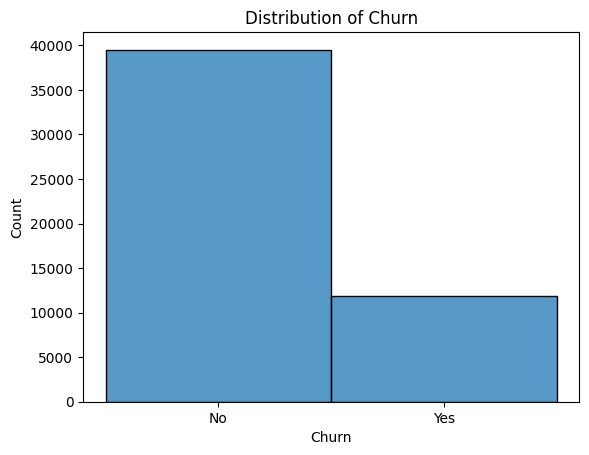

In [ ]:
# Distribution of Churn
import seaborn as sns
from matplotlib import pyplot as plt

# Create a new column 'Churn_Label' based on the mapping of boolean values to 'No' and 'Yes'
customer['Churn_Label'] = customer['Churn'].map({False: 'No', True: 'Yes'})

# Create a histogram plot to visualize the distribution
sns.histplot(x='Churn_Label', data=customer)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.show()

From this graph, we can see that a majority of people tend to stay rather than churn, implying a positive customer experience with Contoso.

Below, we can see the income distribution of the churn model to infer what groups are more likely to cancel their subscription.

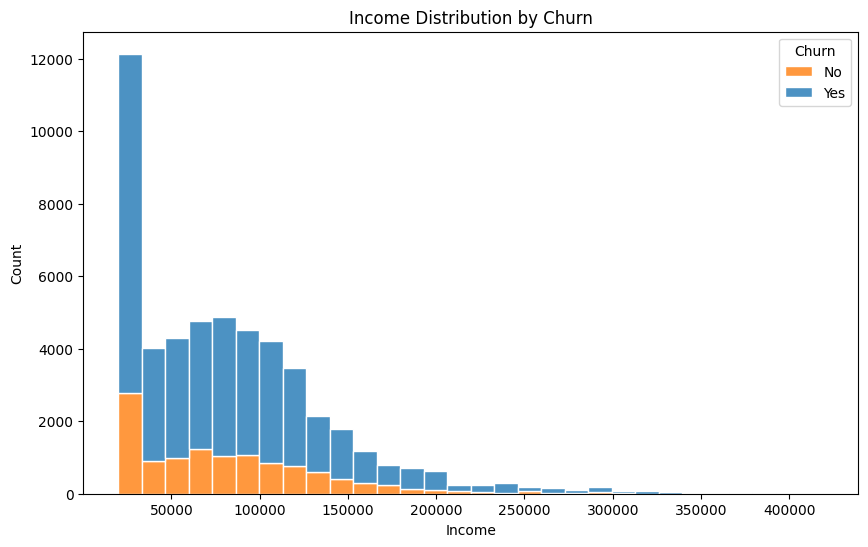

In [ ]:
plt.figure(figsize=(10,6))

sns.histplot(data=customer, x='Income', hue='Churn', bins=30, multiple='stack', edgecolor='w', alpha=0.8)

plt.title('Income Distribution by Churn')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

From this graph, we can see that someone who makes between $25,000 and $37,500 are the most likely to churn from the organization. This implies that the subscription is much to expensive for them.

Below we can see the specific percentages for the income levels of churn.

In [ ]:
# Churn percentage for difference income levels
income_churn_percentage = customer.groupby('Income')['Churn'].mean() * 100

print(income_churn_percentage)

Income
20000.000000     22.839506
20039.388367     40.000000
20098.691532      0.000000
20125.931120     72.727273
20179.489252      0.000000
                   ...    
388251.068900     0.000000
388611.873710     0.000000
398581.571151    96.000000
405993.605700     0.000000
419076.115889    72.222222
Name: Churn, Length: 4194, dtype: float64


High Churn Rates:

*   Income level 20,039 has a churn rate of 40%
*   Income level 20,126 has a churn rate of 72.73%
*   Income level 398,582  has a churn rate of 96%
*   Income level 419,076 has a churn rate of 72%

Low Churn Rates:

* Income level 20,099 has a churn rate of 0%.
* Income level 20,179 has a churn rate of 0%.
* Income level 388,251 has a churn rate of 0%.
* Income level 405,994 has a churn rate of 0%.




Here, we can see the distribution of Customer Satisfaction by Churn using a Bar chart.

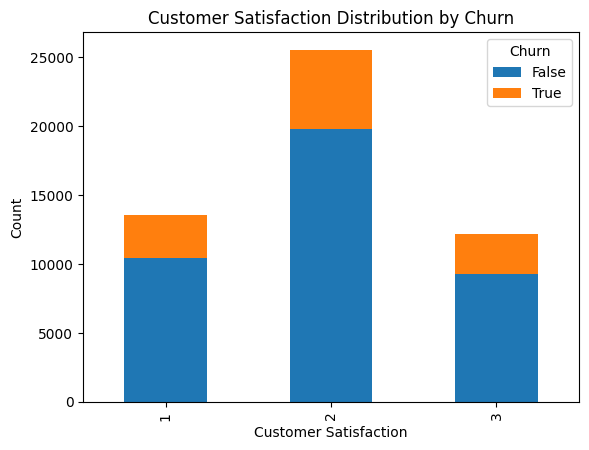

In [ ]:
count = customer.groupby(['CustomerSatisfaction', 'Churn']).size().unstack()

df = count.plot(kind='bar', stacked=True)

# Create a bar chart
plt.title('Customer Satisfaction Distribution by Churn')
plt.xlabel('Customer Satisfaction')
plt.ylabel('Count')
plt.show()

This shows us that a majority of customers are mildly satisfied, giving a medium score of 2/3.

In [ ]:
# Churn percentage for difference customer satisfaction levels
customer_satisfaction_churn_percentage = customer.groupby('CustomerSatisfaction')['Churn'].mean() * 100

print(customer_satisfaction_churn_percentage)

CustomerSatisfaction
1    22.863248
2    22.582792
3    24.125502
Name: Churn, dtype: float64


22.86% of customers with satisfaction level 1 churn

22.58% of customers with satisfaction level 2 churn

24.13% of customers with satisfaction level 3 churn


Here is the distribution of auto-renew by churn. This graph shows how likely a person who has auto-renew on is to churn.

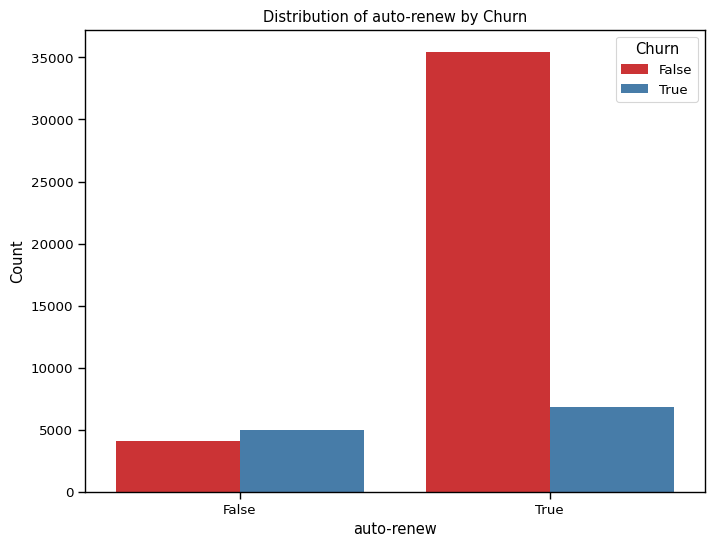

In [ ]:
sns.set_context("paper", font_scale=1.1)
plt.figure(figsize=(8, 6))

# Distribution of auto-renew by churn
ax = sns.countplot(x='is_auto_renew', hue='Churn', data=customer, palette='Set1')

ax.set_ylabel('Count')
ax.set_xlabel('auto-renew')
ax.set_title('Distribution of auto-renew by Churn')

ax.legend(title='Churn', loc='upper right')

plt.show()

The majority of customers with auto-renew do not churn. Customers without auto-renew are more likely to churn compared to those with auto-renew enabled.

Distribution of Occuptation by Churn

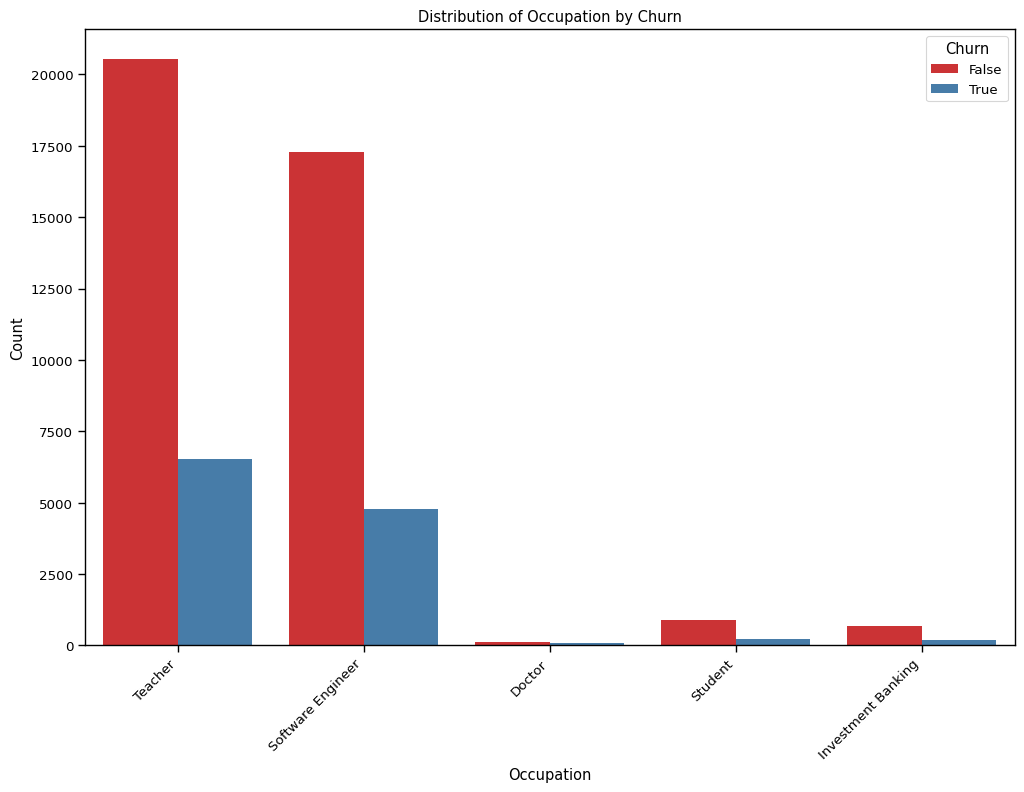

In [ ]:
sns.set_context("paper", font_scale=1.1)
plt.figure(figsize=(12, 8))

# Use countplot to show the distribution
ax = sns.countplot(x='Occupation', hue='Churn', data=customer, palette='Set1')

ax.set_ylabel('Count')
ax.set_xlabel('Occupation')
ax.set_title('Distribution of Occupation by Churn')

ax.legend(title='Churn', loc='upper right')

plt.xticks(rotation=45, ha='right')

plt.show()

Next, we see the distribution of loyalty age (how long a person has been a loyalty member) at Contoso.

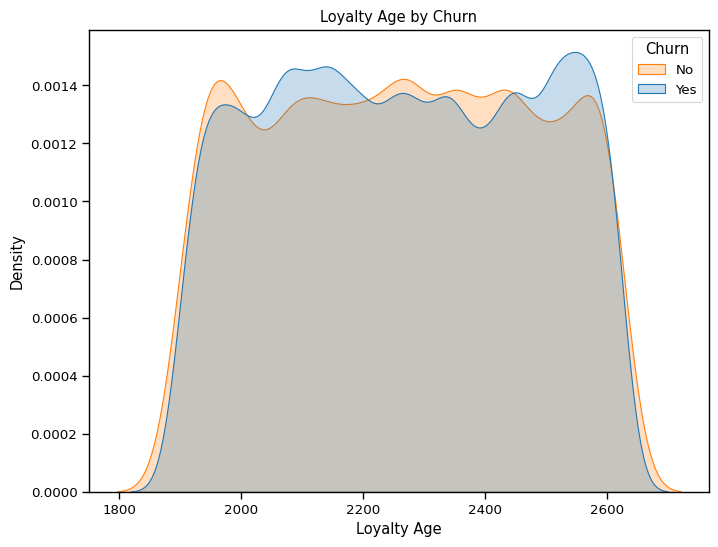

In [ ]:
plt.figure(figsize=(8,6))

sns.kdeplot(data=customer, x='LoyaltyAge', hue='Churn', fill=True, common_norm=False)

plt.title('Loyalty Age by Churn')
plt.xlabel('Loyalty Age')
plt.ylabel('Density')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

Here is the distribution of Subscription Amount by Churn. This table shows that the data is pretty evenly spread in terms of the datapoints of churn true versus false based on subscription amount, implying that this is a fair category to use for classification.

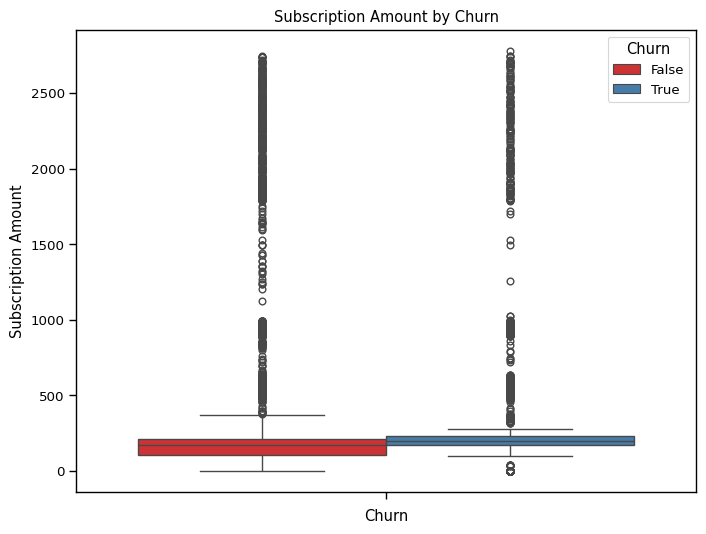

In [ ]:
plt.figure(figsize=(8, 6))

# Create box plot
sns.boxplot(data=customer, hue='Churn', y='SubscriptionAmount', palette='Set1')
plt.title('Subscription Amount by Churn')
plt.xlabel('Churn')
plt.ylabel('Subscription Amount')
plt.show()

This plot tells about the churn rate for subscription amounts within Contoso.

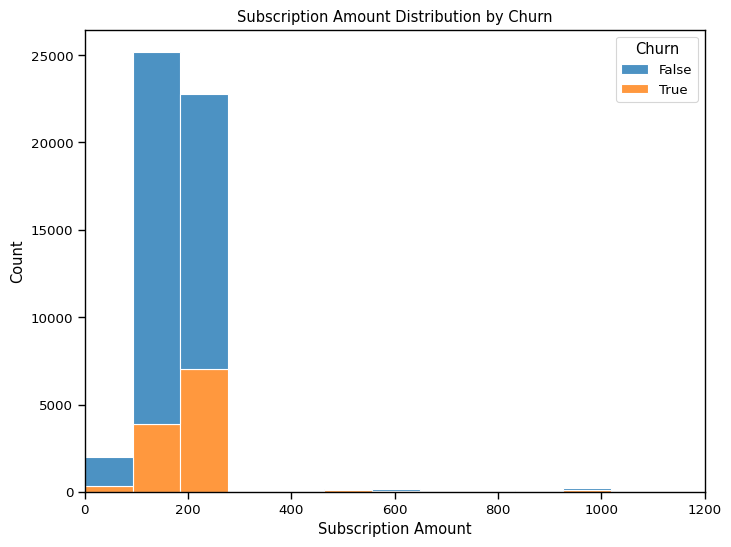

In [ ]:
plt.figure(figsize=(8, 6))

sns.histplot(data=customer, x='SubscriptionAmount', hue='Churn', bins=30, multiple='stack', edgecolor='w', alpha=0.8)
plt.title('Subscription Amount Distribution by Churn')
plt.xlabel('Subscription Amount')
plt.ylabel('Count')

plt.xlim(0,1200)
plt.show()

Distribution of Total Subscription Length by Churn

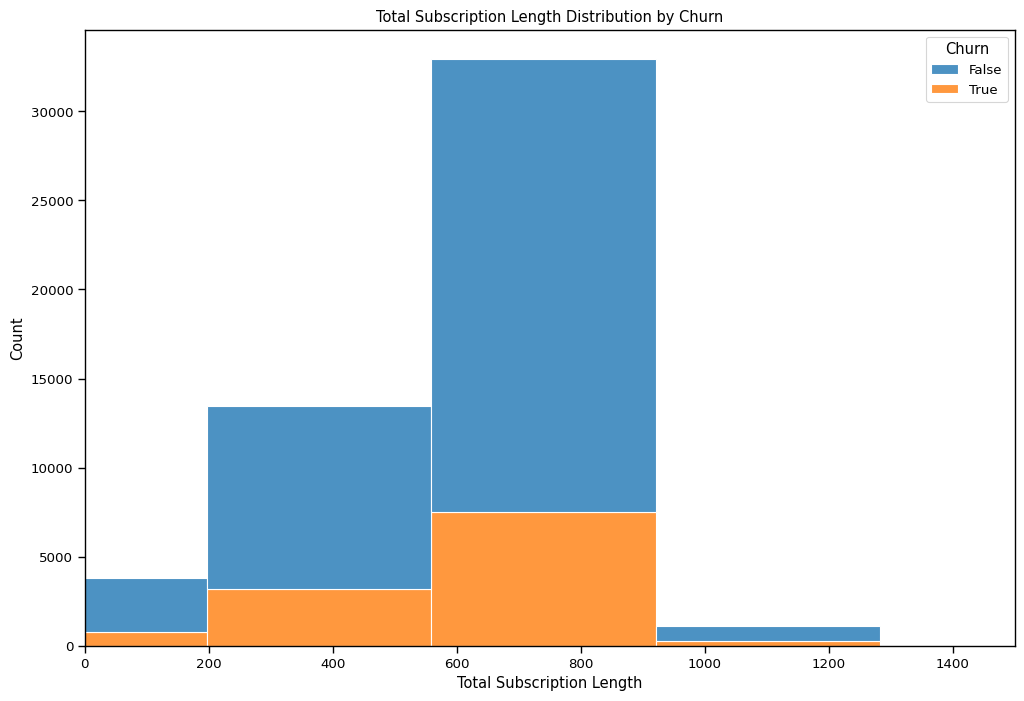

In [ ]:
plt.figure(figsize=(12, 8))

sns.histplot(data=customer, x='TotalSubscriptionLength', hue='Churn', bins=50, multiple='stack', edgecolor='w', alpha=0.8)
plt.title('Total Subscription Length Distribution by Churn')
plt.xlabel('Total Subscription Length')
plt.ylabel('Count')

plt.xlim(0,1500)
plt.show()

Now that our initial analysis is complete, let's create our model. Here, we use a Random Forest classifier to prevent overfitting.

In [ ]:
X = customer_encoded.drop('Churn', axis=1)  # Features
y = customer_encoded['Churn']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

In [ ]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-Score:', f1_score(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.8964442279590843
Precision: 0.7766695576756288
Recall: 0.7657118426678068
F1-Score: 0.771151776103337
ROC-AUC: 0.8503679072031942


We can see that the accuracy of our model was high, with decent percentages and rates for the common statistics of a random forest classifier.

Below, let's view the confusion matrix for the classifier.

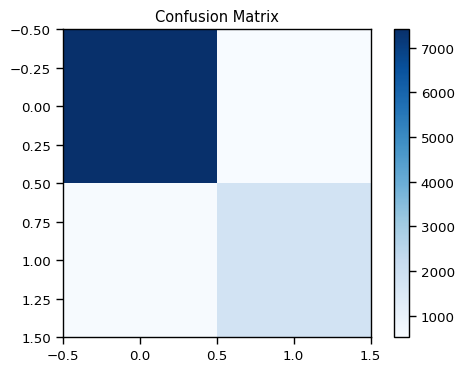

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

The confusion matrix shows that the model correctly predicted customers who did not churn, but did a poor job predicting customers who did.

Next, let's view the feature importance of the classifier.

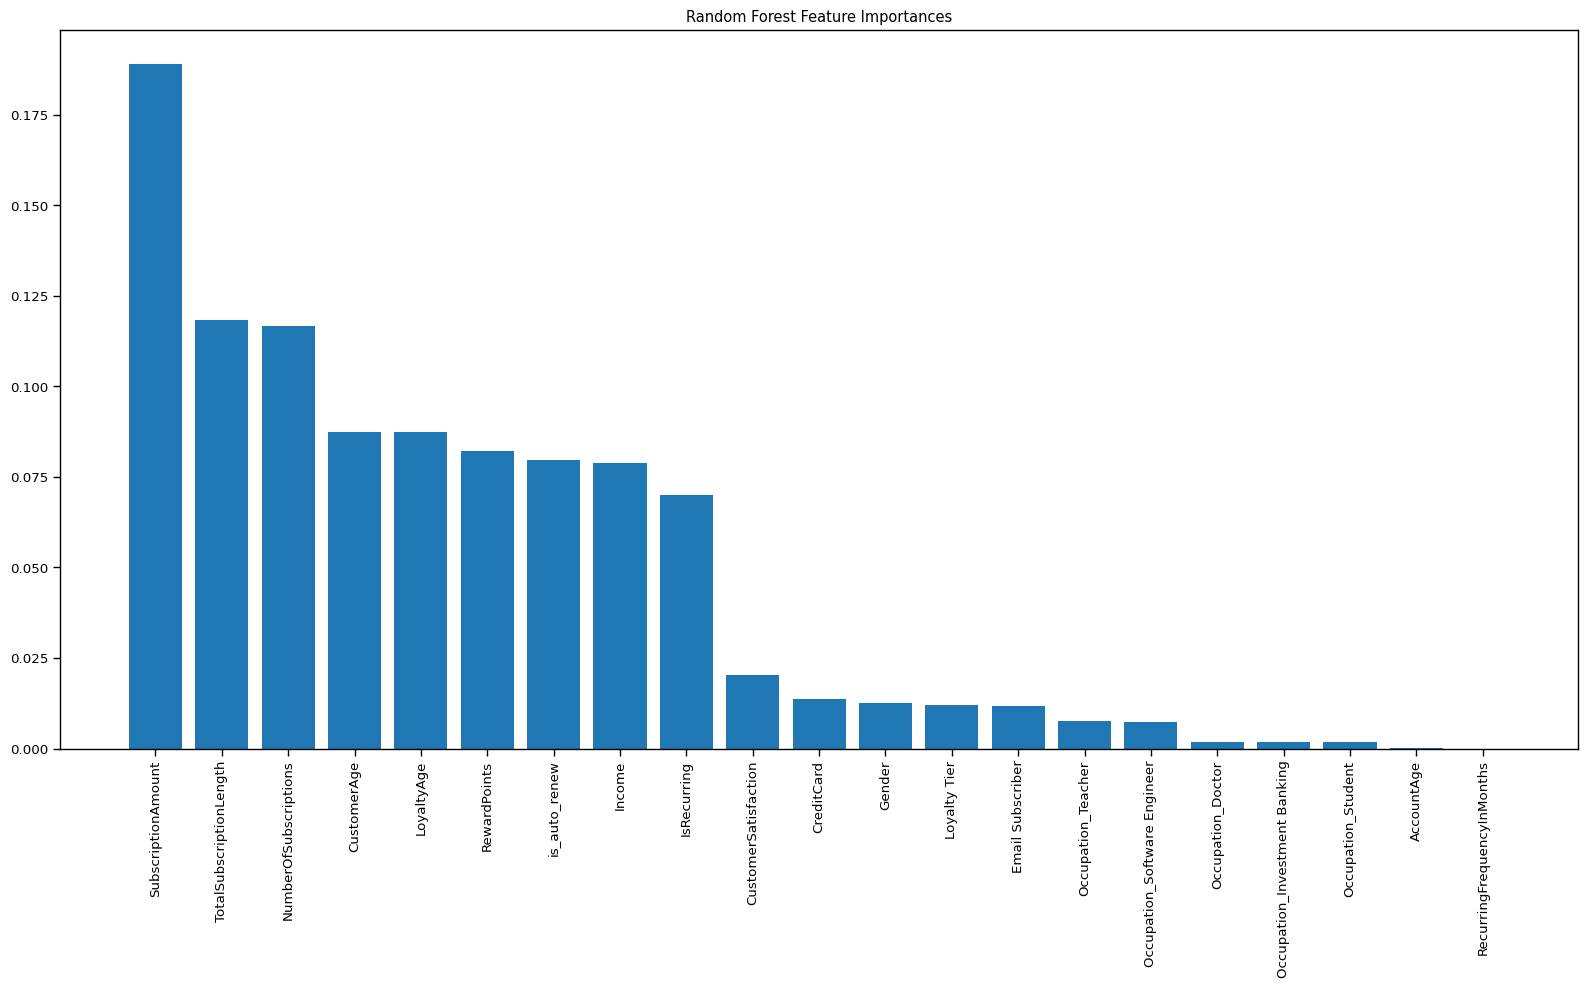

,Gender,Loyalty Tier,Email Subscriber,Income,CustomerSatisfaction,RewardPoints,CreditCard,NumberOfSubscriptions,TotalSubscriptionLength,CustomerAge,...,AccountAge,SubscriptionAmount,IsRecurring,is_auto_renew,RecurringFrequencyInMonths,Occupation_Doctor,Occupation_Investment Banking,Occupation_Software Engineer,Occupation_Student,Occupation_Teacher
25516,0,2,True,81631.132655,2,28,False,21,825,9283,...,1863,172,True,True,1,0,0,1,0,0
40392,0,2,False,66580.936984,2,21,False,27,822,4361,...,1863,149,True,True,1,0,0,1,0,0
37192,0,2,False,59729.333922,2,15,True,16,670,19291,...,1863,149,True,True,1,0,0,1,0,0
10406,1,2,False,81436.131614,1,171,True,27,821,19752,...,1863,235,True,True,1,0,0,1,0,0
8297,1,2,False,86131.980210,2,208,True,27,821,8105,...,1863,189,True,True,1,0,0,0,0,1


In [ ]:
# ======================= Feature Importance =======================
feature_importances = pd.DataFrame({'feature': X_train.columns,
                                    'importance': rf_classifier.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(16, 10))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.title('Random Forest Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

X_test.head(5)

The feature importance clearly shows a correlation between Subscription price / amount and the rate of churn. It also shows that the length for which they have been subscribed thusfar plays a role in prediction.

Next, let's view the partial dependence plots for gender and loyalty.

<Figure size 1200x600 with 0 Axes>

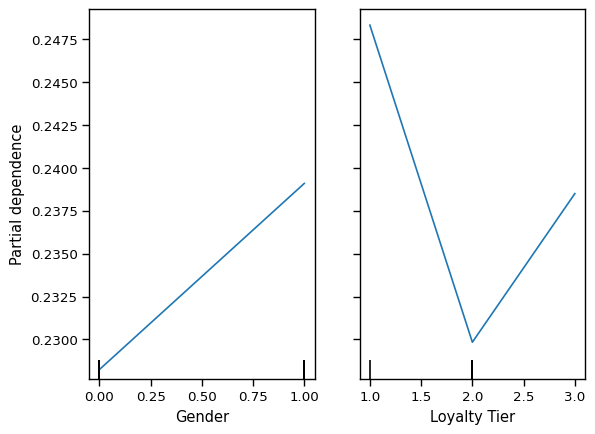

In [ ]:
# ======================= Partial Dependence Plots (PDP) =======================
# Feature Importance Analysis
feature_importances = rf_classifier.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
features = X.columns[sorted_idx]
importance = feature_importances[sorted_idx]

# Partial Dependence Plots
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
display = PartialDependenceDisplay.from_estimator(rf_classifier, X_train, features=[0, 1], feature_names=X.columns)

These plots show that men are more likely to churn than women, and that those of the lower loyalty tier are the most likely to churn, while those in the middle tier are least likely to churn.

Below, let's view the SHAP Plots for this data

In [ ]:
# ======================= SHAP Analysis =======================
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)
# SHAP Summary Plot
plt.figure(figsize=(12, 20))  # Create a new figure
shap.summary_plot(shap_values, X_test)

# SHAP Force Plot
plt.figure()  # Create another figure
shap.force_plot(explainer.expected_value[0], shap_values[0][0, :], X_test.iloc[0, :], matplotlib=True)

These plots reinforce the knowledge that SubscriptionHistory and SubscriptionLength play a huge role in this classifier, and that these are the main two features to keep an eye on when predicting churn for this data.